In [53]:
# Hoeffding Tree with Sample Weights and with Reservoir Sampling 

In [54]:
# IMPORT LIBRARIES
import pyspark
from pyspark.sql import DataFrame
from sklearn.model_selection import train_test_split

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as f
from pyspark.sql import types as t
import random
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit

from numpy import array
import numpy as np
import pandas as pd
import datetime
from pyspark.sql.window import Window
from skmultiflow.trees import HoeffdingTree, HoeffdingTreeClassifier

In [55]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Hoeffding Tree") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

In [56]:
spark = init_spark()

In [57]:
# prepare the data set
filename = "iot_telemetry_data.csv"
df = spark.read.csv(filename, inferSchema=True, header=True)

In [58]:
# convert unix epochs to datetime
df = df.withColumn('timestamp', f.date_format(df.ts.cast(dataType=t.TimestampType()), "yyyy-MM-dd hh:mm:ss")) 

In [59]:
#explore the data frame
df.describe()

DataFrame[summary: string, ts: string, device: string, co: string, humidity: string, lpg: string, smoke: string, temp: string, timestamp: string]

In [17]:
# drop the duplicates 
df.drop_duplicates()

DataFrame[ts: double, device: string, co: double, humidity: double, light: boolean, lpg: double, motion: boolean, smoke: double, temp: double, timestamp: string]

In [18]:
#convert the Boolean True/False values to Interger 1/0
df = df.withColumn("light", df["light"].cast("integer"))
df[df["light"]==1].count()
# 0 - for 292649 data points the label is "light off"
# 1 - for 112522 data points the label is "light on"
# => 112522/(112522+292649) = 28 % - light on =1
# => imbalanced data set - 28% minority class

112527

In [19]:
#select the features and the target label
#we exclude the timestamp and the device id
feature_cols = ['co', 'humidity', 'lpg', 'motion','smoke','temp']
X = df[feature_cols] # Features
y = df['light'] # Target label

In [20]:
# Analysis of the class distribution
df=pd.read_csv("iot_telemetry_data.csv")
df["light"]=df["light"].astype(int)
df["motion"]=df["motion"].astype(int)
period_df = df[["ts", "light"]]
period_df['light'].describe()

count    405184.000000
mean          0.277718
std           0.447874
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: light, dtype: float64

In [24]:
#sum over period of 5 min
period_df.ts = pd.to_datetime(period_df["ts"], unit = 's')
period_df.resample('5T', on='ts').sum()

/home/maria/miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,light,light off,light on
ts,,,
2020-07-12 00:00:00,35,90,35
2020-07-12 00:05:00,45,132,45
2020-07-12 00:10:00,45,129,45
2020-07-12 00:15:00,49,127,49
2020-07-12 00:20:00,52,131,52
...,...,...,...
2020-07-19 23:40:00,43,125,43
2020-07-19 23:45:00,43,126,43
2020-07-19 23:50:00,44,128,44


In [25]:
#sum over period of 30 min
period_30=period_df.resample('30T', on='ts').sum()
print(period_30["light"])

ts
2020-07-12 00:00:00    274
2020-07-12 00:30:00    295
2020-07-12 01:00:00    304
2020-07-12 01:30:00    316
2020-07-12 02:00:00    320
                      ... 
2020-07-19 22:00:00    254
2020-07-19 22:30:00    254
2020-07-19 23:00:00    264
2020-07-19 23:30:00    265
2020-07-20 00:00:00     32
Freq: 30T, Name: light, Length: 385, dtype: int64


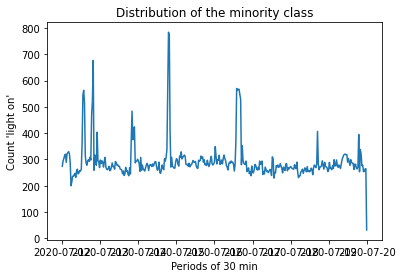

In [26]:
#plot count 'light on' every 30 min
plt.xlabel("Periods of 30 min")
plt.ylabel("Count 'light on'")
plt.title("Distribution of the minority class")
plt.plot(period_30.index, period_30.light)

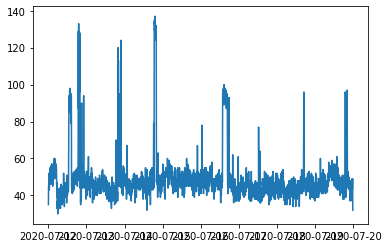

In [27]:
#plot day total light on every 5 min
period_5=period_df.resample('5T', on='ts').sum()
plt.plot(period_df.resample('5T', on='ts').sum().index, period_5.light)

<ipython-input-34-f38c25f460ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df["light off"]= (period_df["light"] + 1).mod(2)
<ipython-input-34-f38c25f460ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df["light on"]=period_df["light"]


<AxesSubplot:title={'center':'Distribution minority vs majority class'}, xlabel='ts'>

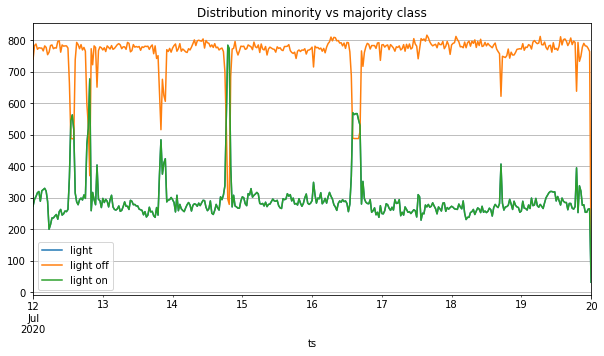

In [34]:
# Plot the majority class "light off" as well
period_df["light off"]= (period_df["light"] + 1).mod(2)
period_df["light on"]=period_df["light"]
period_df.drop(["light"], axis=1)
period2 = period_df.resample('30T', on='ts').sum()
# plt.plot(x=period2.index, y=[period2.light, period2.lightoff], kind="bar")
period2.plot(figsize=(10,5), grid=True, title="Distribution minority vs majority class" )

<AxesSubplot:xlabel='ts'>

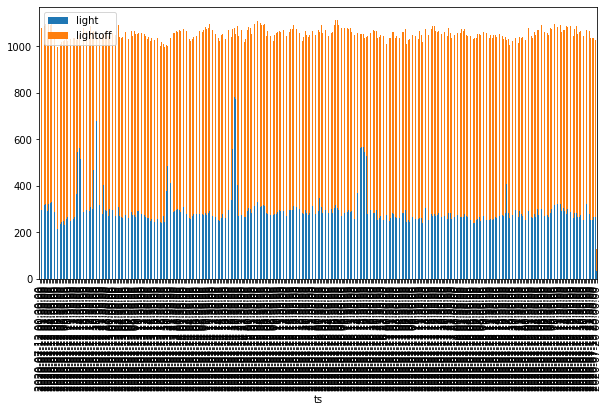

In [22]:
period2.plot(figsize=(10,5), kind="bar",stacked=True)

In [35]:
#split dataset in features and target label
X = df[feature_cols] # Features
y = df['light'] # Target label
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=0)

In [36]:
X_test

,co,humidity,lpg,motion,smoke,temp
32759,0.004928,52.200000,0.007619,0,0.020321,22.300000
23643,0.003006,75.400002,0.005328,0,0.013869,19.500000
18177,0.002840,75.000000,0.005114,0,0.013275,19.299999
274290,0.001376,76.599998,0.003028,0,0.007585,19.900000
186474,0.005024,52.800000,0.007726,0,0.020626,22.700000
...,...,...,...,...,...,...
244298,0.006207,52.200000,0.009004,0,0.024289,21.800000
32,0.004391,78.599998,0.007009,0,0.018589,27.000000
366038,0.005756,50.600000,0.008526,0,0.022915,22.900000
77469,0.003745,76.400002,0.006247,0,0.016437,19.700001


In [37]:
# train the Hoeffding Tree on the entire data set (not incrementally)
ht_full = HoeffdingTreeClassifier()

In [34]:
X = X_train
y = y_train.to_numpy()
classes=[0,1]

In [35]:
# Apply sample weights
from sklearn.utils.class_weight import compute_sample_weight
y=y_train.to_numpy()
sample_weight=compute_sample_weight(class_weight='balanced', y=y)
print(sample_weight)

[0.69231233 0.69231233 0.69231233 ... 0.69231233 0.69231233 0.69231233]


In [36]:
# train the model
ht_full.fit(X.to_numpy(),y,classes, sample_weight)

HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                        leaf_prediction='nba', max_byte_size=33554432,
                        memory_estimate_period=1000000, nb_threshold=0,
                        no_preprune=False, nominal_attributes=None,
                        remove_poor_atts=False, split_confidence=1e-07,
                        split_criterion='info_gain', stop_mem_management=False,
                        tie_threshold=0.05)

In [37]:
# predict the class label for test dataset
y_pred = ht_full.predict(X_test.to_numpy())

[0 0 0 ... 0 0 0]


In [38]:
# What is the performance of this classifier?
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [39]:
# Accuracy by comparing test set values and predicted values

print("Accuracy (test set):", accuracy_score(y_test.to_numpy(), y_pred))
# Accuracy (test set):  0.984533877389845

Accuracy (test set): 0.984533877389845


In [44]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weight_test=compute_sample_weight(class_weight='balanced', y=y_test.to_numpy())
print(sample_weight_test)

ht_full_mean_accuracy = ht_full.score(X_test.to_numpy(), y_test.to_numpy(), sample_weight_test)

[0.69190137 0.69190137 0.69190137 ... 0.69190137 0.69190137 0.69190137]


In [41]:
print(ht_full_mean_accuracy)
#0.9780584953005323

0.9780584953005323


In [42]:
# Accuracy on the training set
y_pred_train = ht_full.predict(X_train.to_numpy())
print("Accuracy (training set):", accuracy_score(y_train,y_pred_train))
#Accuracy (training set): 0.9848057136686874

Accuracy (training set): 0.9846344140345987


In [43]:
print("F1 score (test set):", f1_score(y_test, y_pred, sample_weight=sample_weight_test))
# F1 score  (test set):  0.9777347167729984

F1 score (test set): 0.9777347167729984


In [44]:
print("Recall score (test set):", recall_score(y_test, y_pred))
# Recall score (test set):  0.9635166399715251

Recall score (test set): 0.9635166399715251


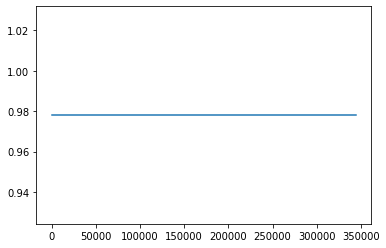

In [45]:
# plot the score per number of samples 
#(for the Full Tree the score will be the same)
n_samples = len(X_train.to_numpy())
plt.plot([0,n_samples], [ht_full_mean_accuracy, ht_full_mean_accuracy])

In [46]:
# Conclusion: As the data set is imbalanced, the Hoeffding Tree classifier 
# is biased towards the majority class

In [49]:
# Now stream the data points one at a time
# We present each data point to the Hoeffding Tree algorithm one at a time

In [38]:
# Create a Hoeffding Tree model 
# This model will be fit incrementally
ht_plus = HoeffdingTreeClassifier()

In [42]:
# Incremental Training 
# Show the F-score every 100 samples. Use holdout test set
import datetime
from sklearn.metrics import f1_score
# Apply sample weights
from sklearn.utils.class_weight import compute_sample_weight
y=y_train.to_numpy()
sample_weight=compute_sample_weight(class_weight='balanced', y=y)

train_arr = X_train.to_numpy()
result_f_scores=[]
accuracy_checkpoint=100
nbr_samples = 0
old_score = -1
N=1
for i in range(len(train_arr)):
    # We show to the algorithm N samples and their corresponing class labels
    # where N=1
    class_label = y_train.to_numpy()[i]
    weight = sample_weight[i]
    train_y = y_train
  

    # take the i-th training sample
    ht_plus = ht_plus.partial_fit(X=train_arr[i].reshape(N,-1) \
                        , y=np.array([class_label]) \
                        , sample_weight=np.array([weight]))

    # What is the score of this tree so far (on the test set)
    if (i % accuracy_checkpoint == 0):
        y_pred = ht_plus.predict(X_test.to_numpy())
        current_f_score = f1_score(y_pred, y_test.to_numpy(), average='weighted')
    
    nbr_samples+=1
    
    result_f_scores.append(current_f_score)
    if current_f_score!= old_score:
        #print(f" F1 score after {i}-th sample: {current_f_score}")
        old_score=current_f_score
    

 F1 score after 0-th sample: 0.9423827661369947
 F1 score after 100-th sample: 0.9481663239476807
 F1 score after 200-th sample: 0.9413981974648028
 F1 score after 300-th sample: 0.9383461641542521
 F1 score after 400-th sample: 0.9488457475960465
 F1 score after 500-th sample: 0.9660244200458331
 F1 score after 600-th sample: 0.9701375655403103
 F1 score after 700-th sample: 0.9648344609996597
 F1 score after 800-th sample: 0.9607080313174299
 F1 score after 900-th sample: 0.9493389560108451
 F1 score after 1000-th sample: 0.9540095090148695
 F1 score after 1100-th sample: 0.9500896573105894
 F1 score after 1200-th sample: 0.9335871467048947
 F1 score after 1300-th sample: 0.9268495442617323
 F1 score after 1400-th sample: 0.9456655101729402
 F1 score after 1500-th sample: 0.9503877588921895
 F1 score after 1600-th sample: 0.9470389616025942
 F1 score after 1700-th sample: 0.9542990386729925
 F1 score after 1800-th sample: 0.9446246044104544
 F1 score after 1900-th sample: 0.951781917

KeyboardInterrupt: 

Text(0, 0.5, 'F-score')

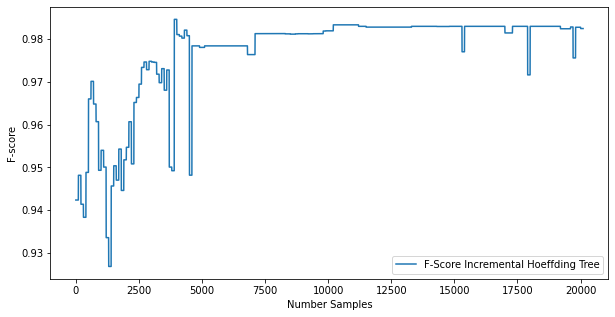

In [47]:
plt.figure(figsize=(10,5))
# plt.plot([0,nbr_samples], [ht_full_mean_accuracy, ht_full_mean_accuracy], label="Hoeffding Tree - Full dataset")
plt.plot(result_f_scores, label="F-Score Incremental Hoeffding Tree")
plt.legend()
plt.xlabel("Number Samples")
plt.ylabel("F-score")

In [51]:
# Incremental Training 
# Show the accuracy every 100 samples. Use holdout test set
import datetime

train_arr = X_train.to_numpy()
result_scores=[]
accuracy_checkpoint=100
nbr_samples = 0
old_score = -1
N=1
for i in range(len(train_arr)):
    # We show to the algorithm N samples and their corresponing class labels
    # where N=1
    class_label = y_train.to_numpy()[i]
    weight = sample_weight[i]
    train_y = y_train
  

    # take the i-th training sample
    ht_plus = ht_plus.partial_fit(X=train_arr[i].reshape(N,-1) \
                        , y=np.array([class_label]) \
                        , sample_weight=np.array([weight]))

    # What is the score of this tree so far (on the test set)
    if (i % accuracy_checkpoint == 0):
        current_score = ht_plus.score(X_test.to_numpy(), y_test.to_numpy(), sample_weight_test)
    
    nbr_samples+=1
    
    result_scores.append(current_score)
    if current_score!= old_score:
        print(f"Score after {i}-th sample: {current_score}")
        old_score=current_score
    
        
# Results




Score after 0-th sample: 0.5000000000000001
Score after 100-th sample: 0.9518466047002583
Score after 200-th sample: 0.9020400061510885
Score after 900-th sample: 0.9325354502806296
Score after 1000-th sample: 0.9020400061510885
Score after 1100-th sample: 0.9023473762018612
Score after 1400-th sample: 0.9023587602778158
Score after 1500-th sample: 0.9023701443537704
Score after 1600-th sample: 0.9356494660984536
Score after 1700-th sample: 0.9419844420005792
Score after 1800-th sample: 0.9383891648276258
Score after 1900-th sample: 0.9489636139715587
Score after 2000-th sample: 0.951255155457793
Score after 2100-th sample: 0.957644337579327
Score after 2200-th sample: 0.9479720506233333
Score after 2300-th sample: 0.9611973180173272
Score after 2400-th sample: 0.9622497706730339
Score after 2500-th sample: 0.9651119780513451
Score after 2600-th sample: 0.9670382890445237
Score after 2700-th sample: 0.967566760852151
Score after 2800-th sample: 0.9659891786081857
Score after 2900-th sa

KeyboardInterrupt: 

In [52]:
print(nbr_samples)

11641


Text(0, 0.5, 'Accuracy')

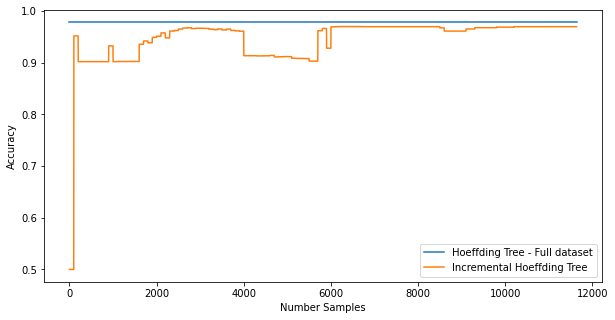

In [53]:
plt.figure(figsize=(10,5))
plt.plot([0,nbr_samples], [ht_full_mean_accuracy, ht_full_mean_accuracy], label="Hoeffding Tree - Full dataset")
plt.plot(result_scores, label="Incremental Hoeffding Tree")
plt.legend()
plt.xlabel("Number Samples")
plt.ylabel("Accuracy")

In [5]:
# train the Hoeffding tree with reservoir sampling
# for every N=100 samples choose randomly and uniformy k=10 elements
# train the Hoeffding Tree with the reservoir


In [61]:
def reservoir_sampling(data, k):
    ''' Return k randomly and uniformly selected items 
        from data
    '''
    reservoir=[]
    for i, element in enumerate(data):
        if (i+1 <=k):
            reservoir.append(element)
        else:
            probability =k/(i+1)
            if random.random()<probability:
                # choose randomly one of the items already selected
                m=random.randint(0,k-1)
                reservoir[m]=element
  
    return reservoir            

In [7]:
# data preparation
df=pd.read_csv("iot_telemetry_data.csv")
df["light"]=df["light"].astype(int)
df["motion"]=df["motion"].astype(int)
select_cols = ['co', 'humidity', 'lpg', 'motion','smoke','temp', 'light']
data = df[select_cols].to_numpy()

In [19]:
# test reservoir sampling
reservoir = reservoir_sampling(data, 5)
for r in reservoir:
    X=r[:-1]  # take the feature columns
    class_label = r[-1] 
#     print(X)
#     print(class_label)
# type(data)
# numpy.ndarray
print("reservoir********************")
print(reservoir)

[2.84008861e-03 7.65000000e+01 5.11438340e-03 0.00000000e+00
 1.32748367e-02 2.00000000e+01]
0.0
[3.66874115e-03 6.24000015e+01 6.15495831e-03 0.00000000e+00
 1.61787517e-02 2.63999996e+01]
1.0
[4.49253512e-03 5.52000008e+01 7.12633408e-03 0.00000000e+00
 1.89201788e-02 2.88999996e+01]
1.0
[1.44256028e-03 7.76999969e+01 3.13306392e-03 0.00000000e+00
 7.86492221e-03 1.92999992e+01]
0.0
[2.74646396e-03 7.26999969e+01 4.99185514e-03 0.00000000e+00
 1.29353992e-02 1.91000004e+01]
1.0
reservoir********************
[array([2.84008861e-03, 7.65000000e+01, 5.11438340e-03, 0.00000000e+00,
       1.32748367e-02, 2.00000000e+01, 0.00000000e+00]), array([3.66874115e-03, 6.24000015e+01, 6.15495831e-03, 0.00000000e+00,
       1.61787517e-02, 2.63999996e+01, 1.00000000e+00]), array([4.49253512e-03, 5.52000008e+01, 7.12633408e-03, 0.00000000e+00,
       1.89201788e-02, 2.88999996e+01, 1.00000000e+00]), array([1.44256028e-03, 7.76999969e+01, 3.13306392e-03, 0.00000000e+00,
       7.86492221e-03, 1.9299

In [63]:
# Hoeffding Tree with reservoir sampling
import random
# 1.accumulate an array on N samples from the stream
# 2.choose k elements with reservoir sampling
# 3.train the model with these k elements
# 4.empty the reservoir

# we apply test then train method 
# i.e we dont split to train and test set
# we use every data sample to test the model and then to train it
# calculate the prequential error

#initialization of variables
N=100 # the number of data points  for reservoir sampling
k=10  # the number of elements in the reservoir
data_tosample=[]
reservoir =[]
numberCorrectPredictions=0
numberTrainingSamplesTotal =0
result_scores=[]

#initialization of the model
ht = HoeffdingTreeClassifier()

for i in range(len(data)):
    if (i % N >0):
        # accumulate N elements in data_tosample array
        data_tosample.append(data[i])
    else:
        # take k ramdom samples from N
        reservoir = reservoir_sampling(data_tosample, k)
        
        # train the Hoeffding tree with these random samples      
        for r in reservoir:
            X=r[:-1]             # take the feature columns
            class_label = r[-1]  # take the label column
            
            # X is a numpy array with shape (n_samples, n_features)
            X=np.array([X])
            
            #use the same sample to test first then to train
            y_predict = ht.predict(X)

            #train the Hoeffding Tree with the sample     
            ht=ht.partial_fit(X = X,y=np.array([class_label]))
            numberTrainingSamplesTotal +=1
                 
            # calculate the current accuracy
            if (y_predict[0] == class_label):
                numberCorrectPredictions+=1
            current_score = numberCorrectPredictions/ numberTrainingSamplesTotal
            result_scores.append(current_score)
        
        # clear the reservoir after training
        reservoir=[]
        data_tosample=[]

Text(0, 0.5, 'Accuracy')

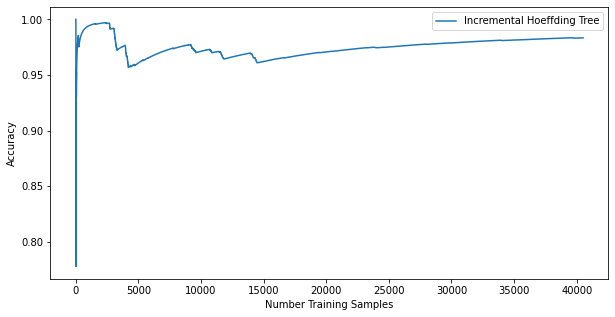

In [64]:
plt.figure(figsize=(10,5))
plt.plot(result_scores, label="Incremental Hoeffding Tree")
plt.legend()
plt.xlabel("Number Training Samples")
plt.ylabel("Accuracy")

In [62]:
# Obtain the F-score
import random
# 1.accumulate an array on N samples from the stream
# 2.choose k elements with reservoir sampling
# 3.train the model with these k elements
# 4.empty the reservoir

# we apply test then train method 
# i.e we dont split to train and test set
# we use every data sample to test the model and then to train it
# calculate the prequential error

#initialization of variables
N=100 # the number of data points  for reservoir sampling
k=10  # the number of elements in the reservoir
data_tosample=[]
reservoir =[]
numberCorrectPredictions=0
numberTrainingSamplesTotal =0
numberTP=0    #true positives
numberFP=0    #false positives
numberFN=0    #false negatives
result_scores=[]
result_f_scores=[]

#initialization of the model
ht = HoeffdingTreeClassifier()

for i in range(len(data)):
    if (i % N >0):
        # accumulate N elements in data_tosample array
        data_tosample.append(data[i])
    else:
        # take k ramdom samples from N
        reservoir = reservoir_sampling(data_tosample, k)
        
        # train the Hoeffding tree with these random samples      
        for r in reservoir:
            X=r[:-1]             # take the feature columns
            class_label = r[-1]  # take the label column
            
            # X is a numpy array with shape (n_samples, n_features)
            X=np.array([X])
            
            #use the same sample to test first then to train
            y_predict = ht.predict(X)

            #train the Hoeffding Tree with the sample     
            ht=ht.partial_fit(X = X,y=np.array([class_label]))
            numberTrainingSamplesTotal +=1
                 
            # calculate the current accuracy
            if (y_predict[0] == class_label):
                numberCorrectPredictions+=1
            if (y_predict[0]==1 and class_label==1):
                numberTP+=1
            if (y_predict[0]==1 and class_label==0):
                numberFP+=1
            if (y_predict[0]==0 and class_label==1):
                numberFN+=1
            current_score = numberCorrectPredictions/ numberTrainingSamplesTotal
            result_scores.append(current_score)
            
            if (((numberTP + numberFP)==0) or ((numberTP + numberFN)==0)):
                current_f_score=0
            else:
                current_f_score = numberTP/(numberTP + 0.5*(numberFP+numberFN))

            result_f_scores.append(current_f_score)
        
        # clear the reservoir after training
        reservoir=[]
        data_tosample=[]

Text(0.5, 0, 'Number Training Samples')

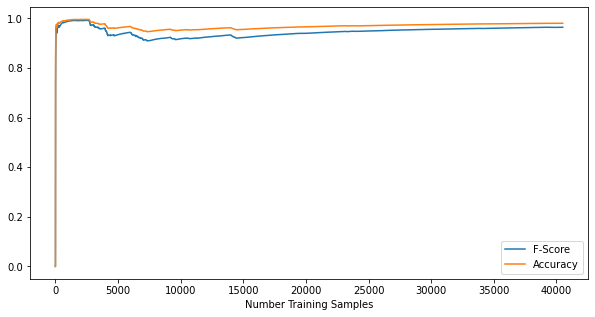

In [63]:
plt.figure(figsize=(10,5))
plt.plot(result_f_scores, label="F-Score")
plt.plot(result_scores, label="Accuracy")
plt.legend()
plt.xlabel("Number Training Samples")

In [64]:
# changing parameters
import random
# 1.accumulate an array on N samples from the stream
# 2.choose k elements with reservoir sampling
# 3.train the model with these k elements
# 4.empty the reservoir

# we apply test then train method 
# i.e we dont split to train and test set
# we use every data sample to test the model and then to train it
# calculate the prequential error

#initialization of variables
N=20 # the number of data points  for reservoir sampling
k=10  # the number of elements in the reservoir
data_tosample=[]
reservoir =[]
numberCorrectPredictions=0
numberTrainingSamplesTotal =0
numberTP=0    #true positives
numberFP=0    #false positives
numberFN=0    #false negatives
result_scores=[]
result_f_scores=[]

#initialization of the model
ht = HoeffdingTreeClassifier()

for i in range(len(data)):
    if (i % N >0):
        # accumulate N elements in data_tosample array
        data_tosample.append(data[i])
    else:
        # take k ramdom samples from N
        reservoir = reservoir_sampling(data_tosample, k)
        
        # train the Hoeffding tree with these random samples      
        for r in reservoir:
            X=r[:-1]             # take the feature columns
            class_label = r[-1]  # take the label column
            
            # X is a numpy array with shape (n_samples, n_features)
            X=np.array([X])
            
            #use the same sample to test first then to train
            y_predict = ht.predict(X)

            #train the Hoeffding Tree with the sample     
            ht=ht.partial_fit(X = X,y=np.array([class_label]))
            numberTrainingSamplesTotal +=1
                 
            # calculate the current accuracy
            if (y_predict[0] == class_label):
                numberCorrectPredictions+=1
            if (y_predict[0]==1 and class_label==1):
                numberTP+=1
            if (y_predict[0]==1 and class_label==0):
                numberFP+=1
            if (y_predict[0]==0 and class_label==1):
                numberFN+=1
            current_score = numberCorrectPredictions/ numberTrainingSamplesTotal
            result_scores.append(current_score)
            
            if (((numberTP + numberFP)==0) or ((numberTP + numberFN)==0)):
                current_f_score=0
            else:
                current_f_score = numberTP/(numberTP + 0.5*(numberFP+numberFN))

            result_f_scores.append(current_f_score)
        
        # clear the reservoir after training
        reservoir=[]
        data_tosample=[]

Text(0.5, 0, 'Number Training Samples')

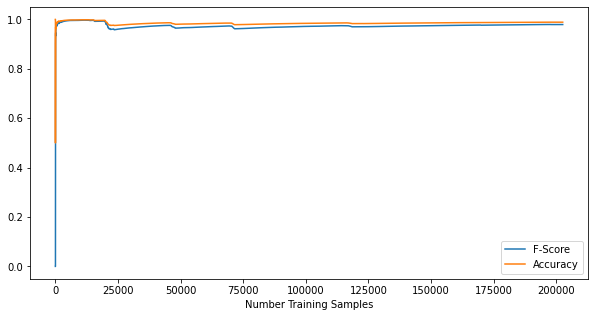

In [65]:
plt.figure(figsize=(10,5))
plt.plot(result_f_scores, label="F-Score")
plt.plot(result_scores, label="Accuracy")
plt.legend()
plt.xlabel("Number Training Samples")

In [66]:
# undersample the majority class only
# use every data point of the minority class
import random
# 1. Accumulate N data points from the majority class in the reservoir
# 2. countMinority =0 -> start training with the minority class
# 3. When the ith>=N+1 data point arrives 
# verify if it is from the minority class
# 4. If Yes, and i< 2*N => use it for training
# 5. If No, use reservoir sampling
# 6. Did we train the model with N points from the minority class
# 7. If Yes then use the reservoir 
# to train the model with N samples from the majority class as well
# 8. empty the reservoir -> go to step1

# we apply test then train method 
# i.e we dont split to train and test set
# we use every data sample to test the model and then to train it
# calculate the prequential error

#initialization of variables
N=5 # the number of data points in the reservoir
reservoir =[]
numberCorrectPredictions=0
numberTrainingSamplesTotal =0
numberTP=0    #true positives
numberFP=0    #false positives
numberFN=0    #false negatives
result_scores=[]
result_f_scores=[]
majorityClass =0
minorityClass =1
countMajority=0
countMinority=0

#initialization of the model
ht = HoeffdingTreeClassifier()

for i in range(len(data)):
    class_label = data[i][-1]  # take the label 

    if (class_label==majorityClass):
        countMajority+=1
        if (len(reservoir) <= N):
            # accumulate N elements in the reservoir
            reservoir.append(data[i])
        else:
            probability=N/countMajority
            if random.random()<probability:
                m=random.randint(0, N-1)
                reservoir[m]=data[i]          
    else:
        if (len(reservoir) > N) : # we need to have N data points in the reservoir before proceeding
            # test and train the Hoeffding tree with the current data point
            countMinority+=1
            
            # take the current data point
            X=data[i][:-1]
            # X is a numpy array with shape (n_samples, n_features)
            X=np.array([X])
            
            #use the same sample to test first then to train
            y_predict = ht.predict(X)

            #train the Hoeffding Tree with the sample     
            ht=ht.partial_fit(X = X,y=np.array([class_label]))
            numberTrainingSamplesTotal +=1
#             print("training with minority***************")
#             print(i)
                 
            # calculate the current accuracy
            if (y_predict[0] == class_label):
                numberCorrectPredictions+=1
            if (y_predict[0]==1 and class_label==1):
                numberTP+=1
            if (y_predict[0]==1 and class_label==0):
                numberFP+=1
            if (y_predict[0]==0 and class_label==1):
                numberFN+=1
            current_score = numberCorrectPredictions/ numberTrainingSamplesTotal
            result_scores.append(current_score)
#             print("correct so far / total training****************")
#             print(numberCorrectPredictions)
#             print(numberTrainingSamplesTotal)
#             print(current_score)
            
            if (((numberTP + numberFP)==0) or ((numberTP + numberFN)==0)):
                current_f_score=0
            else:
                current_f_score = numberTP/(numberTP + 0.5*(numberFP+numberFN))

            result_f_scores.append(current_f_score)
        
        # did we train with N points from the minority class?
        # if Yes we need to train with N points from the reservoir
        # and we will empty the reservoir 
        if (countMinority ==N):
            
            # train the Hoeffding tree with the samples from the reservoir (N from majority class)      
            for r in reservoir:
                X=r[:-1]             # take the feature columns
                class_label = r[-1]  # take the label column
                
                # X is a numpy array with shape (n_samples, n_features)
                X=np.array([X])
                
                #use the same sample to test first then to train
                y_predict = ht.predict(X)

                #train the Hoeffding Tree with the sample     
                ht=ht.partial_fit(X = X,y=np.array([class_label]))
                numberTrainingSamplesTotal +=1
#                 print("majority----------------------")
#                 print(numberTrainingSamplesTotal)

                # calculate the current accuracy
                if (y_predict[0] == class_label):
                    numberCorrectPredictions+=1
                if (y_predict[0]==1 and class_label==1):
                    numberTP+=1
                if (y_predict[0]==1 and class_label==0):
                    numberFP+=1
                if (y_predict[0]==0 and class_label==1):
                    numberFN+=1
                current_score = numberCorrectPredictions/ numberTrainingSamplesTotal
                result_scores.append(current_score)
#                 print("correct so far / total training-----------------")
#                 print(numberCorrectPredictions)
#                 print(numberTrainingSamplesTotal)
#                 print(current_score)
            
                if (((numberTP + numberFP)==0) or ((numberTP + numberFN)==0)):
                    current_f_score=0
                else:
                    current_f_score = numberTP/(numberTP + 0.5*(numberFP+numberFN))

                result_f_scores.append(current_f_score)
                
            # clear the reservoir after training
            reservoir=[]
            countMajority=0
            countMinority =0 


Text(0.5, 0, 'Number Training Samples')

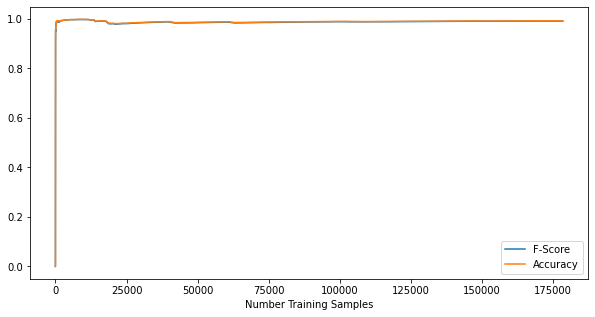

In [67]:
plt.figure(figsize=(10,5))
plt.plot(result_f_scores, label="F-Score")
plt.plot(result_scores, label="Accuracy")
plt.legend()
plt.xlabel("Number Training Samples")

In [68]:
# undersample the majority class only
# use every data point of the minority class
import random
# 1. Accumulate N data points from the majority class in the reservoir
# 2. countMinority =0 -> start training with the minority class
# 3. When the ith>=N+1 data point arrives 
# verify if it is from the minority class
# 4. If Yes, and i< 2*N => use it for training
# 5. If No, use reservoir sampling
# 6. Did we train the model with N points from the minority class
# 7. If Yes then use the reservoir 
# to train the model with N samples from the majority class as well
# 8. empty the reservoir -> go to step1

# we apply test then train method 
# i.e we dont split to train and test set
# we use every data sample to test the model and then to train it
# calculate the prequential error

# data preparation
df=pd.read_csv("iot_telemetry_data.csv")
df["light"]=df["light"].astype(int)
df["motion"]=df["motion"].astype(int)
select_cols = ['co', 'humidity', 'lpg', 'motion','smoke','temp', 'light']
data = df[select_cols].to_numpy()

#initialization of variables
N=10 # the number of data points in the reservoir
reservoir =[]
numberCorrectPredictions=0
numberTrainingSamplesTotal =0
numberTP=0    #true positives
numberFP=0    #false positives
numberFN=0    #false negatives
result_scores=[]
result_f_scores=[]
majorityClass =0
minorityClass =1
countMajority=0
countMinority=0

#initialization of the model
ht = HoeffdingTreeClassifier()

for i in range(len(data)):
    class_label = data[i][-1]  # take the label 

    if (class_label==majorityClass):
        countMajority+=1
        if (len(reservoir) <= N-1):
            # accumulate N elements in the reservoir
            reservoir.append(data[i])
        else:
            probability=N/countMajority
            if random.random()<probability:
                m=random.randint(0, N-1)
                reservoir[m]=data[i]          
    else:
        if (len(reservoir) == N) : # we need to have N data points in the reservoir before proceeding
            # test and train the Hoeffding tree with the current data point
            countMinority+=1
            
            # take the current data point
            X=data[i][:-1]
            # X is a numpy array with shape (n_samples, n_features)
            X=np.array([X])
            
            #use the same sample to test first then to train
            y_predict = ht.predict(X)

            #train the Hoeffding Tree with the sample     
            ht=ht.partial_fit(X = X,y=np.array([class_label]))
            numberTrainingSamplesTotal +=1
#             print("training with minority***************")
#             print(i)
                 
            # calculate the current accuracy
            if (y_predict[0] == class_label):
                numberCorrectPredictions+=1
            if (y_predict[0]==1 and class_label==1):
                numberTP+=1
            if (y_predict[0]==1 and class_label==0):
                numberFP+=1
            if (y_predict[0]==0 and class_label==1):
                numberFN+=1
            current_score = numberCorrectPredictions/ numberTrainingSamplesTotal
            result_scores.append(current_score)
#             print("correct so far / total training****************")
#             print(numberCorrectPredictions)
#             print(numberTrainingSamplesTotal)
#             print(current_score)
            
            if (((numberTP + numberFP)==0) or ((numberTP + numberFN)==0)):
                current_f_score=0
            else:
                current_f_score = numberTP/(numberTP + 0.5*(numberFP+numberFN))
            result_f_scores.append(current_f_score)    
                
        
        # did we train with N points from the minority class?
        # if Yes we need to train with N points from the reservoir
        # and we will empty the reservoir 
        if (countMinority ==N):
            
            # train the Hoeffding tree with the samples from the reservoir (N from majority class)      
            for r in reservoir:
                X=r[:-1]             # take the feature columns
                class_label = r[-1]  # take the label column
                
                # X is a numpy array with shape (n_samples, n_features)
                X=np.array([X])
                
                #use the same sample to test first then to train
                y_predict = ht.predict(X)

                #train the Hoeffding Tree with the sample     
                ht=ht.partial_fit(X = X,y=np.array([class_label]))
                numberTrainingSamplesTotal +=1
#                 print("majority----------------------")
#                 print(numberTrainingSamplesTotal)

                # calculate the current accuracy
                if (y_predict[0] == class_label):
                    numberCorrectPredictions+=1
                if (y_predict[0]==1 and class_label==1):
                    numberTP+=1
                if (y_predict[0]==1 and class_label==0):
                    numberFP+=1
                if (y_predict[0]==0 and class_label==1):
                    numberFN+=1
                current_score = numberCorrectPredictions/ numberTrainingSamplesTotal
                result_scores.append(current_score)
#                 print("correct so far / total training-----------------")
#                 print(numberCorrectPredictions)
#                 print(numberTrainingSamplesTotal)
#                 print(current_score)
            
                if (((numberTP + numberFP)==0) or ((numberTP + numberFN)==0)):
                    current_f_score=0
                else:
                    current_f_score = numberTP/(numberTP + 0.5*(numberFP+numberFN))     
                result_f_scores.append(current_f_score)
                
            # clear the reservoir after training
            reservoir=[]
            countMajority=0
            countMinority =0 
# Result
# correct so far / total training****************
# 0
# 1
# 0.0
# correct so far / total training****************
# 0
# 2
# 0.0
# correct so far / total training****************
# 1
# 3
# 0.3333333333333333
# correct so far / total training****************
# 2
# 4
# 0.5
# correct so far / total training****************
# 3
# 5
# 0.6
# correct so far / total training-----------------
# 4
# 6
# 0.6666666666666666
# correct so far / total training-----------------
# 5
# 7
# 0.7142857142857143
# correct so far / total training-----------------
# 6
# 8
# 0.75
# correct so far / total training-----------------
# 7
# 9
# 0.7777777777777778
# correct so far / total training-----------------
# 8
# 10
# 0.8
# correct so far / total training****************
# 8
# 11
# 0.7272727272727273
# correct so far / total training****************
# 9
# 12
# 0.75
# correct so far / total training****************
# 10
# 13
# 0.7692307692307693
# correct so far / total training****************
# 11
# 14
# 0.7857142857142857

Text(0.5, 0, 'Number Training Samples')

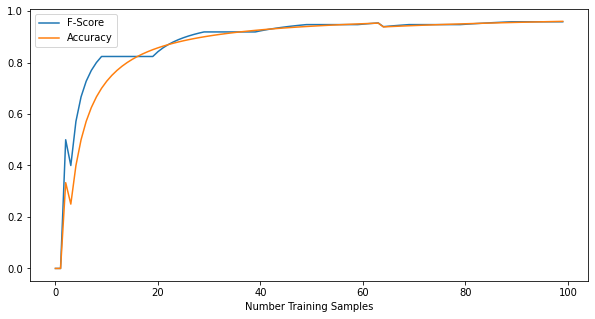

In [70]:
plt.figure(figsize=(10,5))
plt.plot(result_f_scores[:100], label="F-Score")
plt.plot(result_scores[:100], label="Accuracy")
plt.legend()
plt.xlabel("Number Training Samples")